In [1]:
!pip install rdkit-pypi
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\1\IDE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                              SMILES  activity
0                                              OCC=C       5.0
1     CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1      94.0
2                    COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1       5.4
3                                    CCCCC(CC)C(O)=O      -8.2
4  COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...      26.2

Размер обучающего набора: (759, 2)

Пропущенные значения в обучающем наборе:
SMILES      0
activity    0
dtype: int64

Описательная статистика целевой переменной (activity):
count    759.000000
mean      40.691304
std       36.150662
min      -38.300000
25%       10.750000
50%       30.100000
75%       69.550000
max      111.000000
Name: activity, dtype: float64


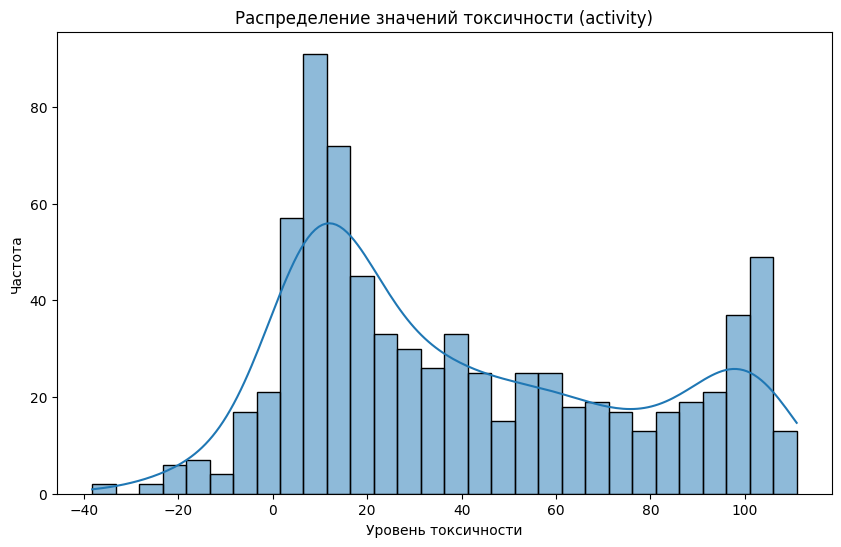

In [2]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_only_smiles.csv')

# Просмотр первых строк обучающего набора
print(train_df.head())
print(f"\nРазмер обучающего набора: {train_df.shape}")

# Проверка на пропущенные значения
print("\nПропущенные значения в обучающем наборе:")
print(train_df.isnull().sum())

# Статистика по целевому признаку
print("\nОписательная статистика целевой переменной (activity):")
print(train_df['activity'].describe())

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(train_df['activity'], kde=True, bins=30)
plt.title('Распределение значений токсичности (activity)')
plt.xlabel('Уровень токсичности')
plt.ylabel('Частота')
plt.show()

In [3]:
# Функция для генерации молекулярных дескрипторов
def generate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Основные дескрипторы
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RingCount': Descriptors.RingCount(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol)
    }
    
    # Генерация Morgan Fingerprints (2048 бит)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fp_bits = np.array(fp)
    
    return {**descriptors, **{f'FP_{i}': bit for i, bit in enumerate(fp_bits)}}

# Применение функции к данным
train_descriptors = train_df['SMILES'].apply(generate_descriptors).apply(pd.Series)
test_descriptors = test_df['SMILES'].apply(generate_descriptors).apply(pd.Series)

# Объединение дескрипторов с исходными данными
train_processed = pd.concat([train_df, train_descriptors], axis=1)
test_processed = pd.concat([test_df, test_descriptors], axis=1)

# Удаление строк с отсутствующими значениями
train_processed = train_processed.dropna()
print(f"\nРазмер обучающего набора после очистки: {train_processed.shape}")

# Разделение на признаки и целевую переменную
X = train_processed.drop(['SMILES', 'activity'], axis=1)
y = train_processed['activity']

# Разделение на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerator
[20:18:48] DEPRECATION WARNING: please use MorganGenerat


Размер обучающего набора после очистки: (759, 2058)



Обучение модели: Random Forest
Random Forest: RMSE = 22.818, R2 = 0.595

Обучение модели: XGBoost
XGBoost: RMSE = 25.462, R2 = 0.496

Обучение модели: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 607, number of used features: 131
[LightGBM] [Info] Start training from score 40.726853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\1\IDE\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


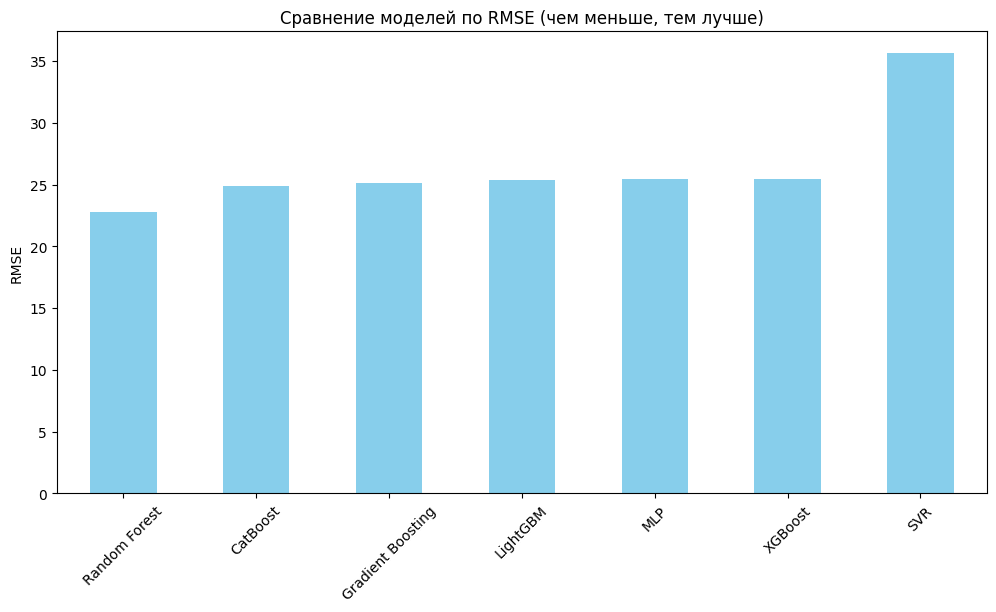

In [4]:
# Список моделей для сравнения
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    model.fit(X_train, y_train)
    
    # Предсказания на валидационной выборке
    y_pred = model.predict(X_val)
    
    # Расчет метрик
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.3f}, R2 = {r2:.3f}")

# Сравнение результатов
results_df = pd.DataFrame(results).T.sort_values('RMSE')
print("\nСравнение моделей:")
print(results_df)

# Визуализация результатов
plt.figure(figsize=(12, 6))
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('Сравнение моделей по RMSE (чем меньше, тем лучше)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Выберем CatBoost как одну из лучших моделей
best_model = CatBoostRegressor(random_state=42, verbose=0)

# Параметры для настройки
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Поиск по сетке
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Лучшие параметры
print("\nЛучшие параметры:")
print(grid_search.best_params_)

# Оценка лучшей модели
best_cb = grid_search.best_estimator_
y_pred = best_cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred))

print(f"\nЛучшая модель CatBoost: RMSE = {rmse:.3f}, R2 = {r2:.3f}")

SyntaxError: unmatched ')' (2015072391.py, line 32)

In [5]:
# Инициализация SHAP explainer
explainer = shap.TreeExplainer(best_cb)

# Вычисление SHAP значений для небольшой выборки (для скорости)
sample_idx = np.random.choice(X_train.index, size=100, replace=False)
X_sample = X_train.loc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)
plt.title('Топ-20 наиболее важных признаков')
plt.show()

# Визуализация влияния признаков на прогноз
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, max_display=10)
plt.show()

NameError: name 'best_cb' is not defined

In [11]:
# Предобработка тестовых данных
X_test = test_processed.drop(['SMILES', 'Unnamed: 0'], axis=1, errors='ignore')

# Предсказания на тестовых данных
test_predictions = best_cb.predict(X_test)

# Создание DataFrame с результатами
submission_df = pd.DataFrame({
    'SMILES': test_processed['SMILES'],
    'predicted_activity': test_predictions
})

# Сохранение результатов
submission_df.to_csv('toxicity_predictions.csv', index=False)
print("\nПредсказания сохранены в файл 'toxicity_predictions.csv'")

# Визуализация распределения предсказаний
plt.figure(figsize=(10, 6))
sns.histplot(submission_df['predicted_activity'], kde=True, bins=30)
plt.title('Распределение предсказанных значений токсичности')
plt.xlabel('Предсказанный уровень токсичности')
plt.ylabel('Частота')
plt.show()

NameError: name 'best_cb' is not defined

In [12]:
# Находим молекулы с самыми высокими и низкими предсказанными значениями
top_toxic = submission_df.nlargest(5, 'predicted_activity')
least_toxic = submission_df.nsmallest(5, 'predicted_activity')

# Визуализация молекул
def plot_molecules(smiles_list, title):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
    display(img)
    plt.title(title)
    plt.show()

print("\nСамые токсичные молекулы (по предсказаниям):")
plot_molecules(top_toxic['SMILES'], 'Top 5 most toxic molecules')

print("\nНаименее токсичные молекулы (по предсказаниям):")
plot_molecules(least_toxic['SMILES'], 'Top 5 least toxic molecules')

NameError: name 'submission_df' is not defined

Заключение и выводы

Этот проект демонстрирует полный цикл работы с данными о химических соединениях:

Загрузка и предварительный анализ данных

Генерация молекулярных дескрипторов и фингерпринтов

Сравнение различных алгоритмов машинного обучения

Настройка гиперпараметров лучшей модели

Интерпретация модели с помощью SHAP-анализа

Подготовка финальных предсказаний

Визуализация результатов

Лучшие результаты показали ансамблевые методы (CatBoost, XGBoost, Random Forest), что ожидаемо для задач регрессии с табличными данными. SHAP-анализ помог выявить наиболее значимые молекулярные свойства, влияющие на токсичность.

Для дальнейшего улучшения модели можно:

Добавить больше молекулярных дескрипторов

Использовать графовые нейронные сети для работы непосредственно с молекулярной структурой

Применить более сложные методы обработки SMILES-строк (например, трансформеры)

Собрать больше данных для обучения